In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

###  Set all the Constants

In [2]:
IMAGE_SIZE = 256 # size of the potatoe images
BATCH_SIZE= 32 # A standard batch size
CHANNELS = 3 #RGB

### Import data into tensorflow dataset object

In [3]:
# Generates a tf.data.Dataset from image files in a directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomatoeimages",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
# view how many classes there are
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

- The batch size is 501. If we multiply 501 * 32 = 16032, which is close to the actual size 16011. 

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[4 3 9 1 1 9 3 9 9 4 7 0 7 5 8 2 1 2 3 4 6 0 1 8 7 7 0 4 4 0 3 0]


- One batch has 32 images. This data set will have 32 batches, each image 256 by 256 and three RGB channels (Red, blue, green)

### Visualize some of the images from our dataset

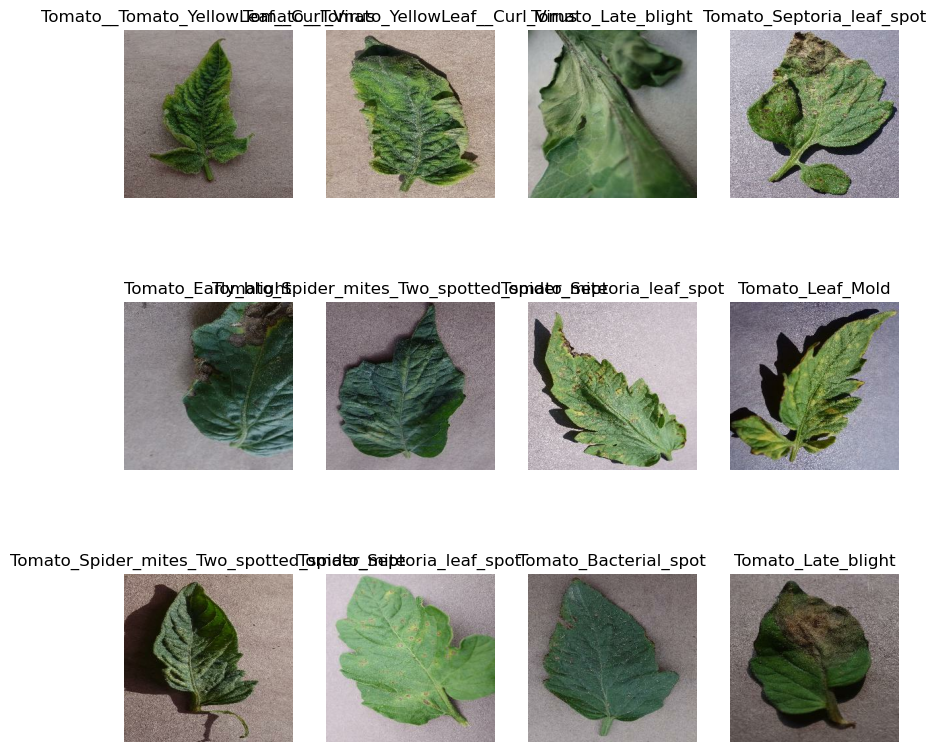

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

400

In [11]:

len(val_ds)

50

In [12]:
len(test_ds)

51

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

- prefetch and cache improves performance. prefetch does this by preloading the data in the cpu while GPU is training the data during the iterations (epoche), Cache also saves time while reading the images

### Building the model

### Creating a layer for resizing and normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it


In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data augmentation

- Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

- We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# define Number of classes  or type of tomatoe's condition
n_classes = 10

model_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_1.build(input_shape=input_shape)

In [28]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

### Compiling the model

- We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [29]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_1.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
400/400 [==============================] - 540s 1s/step - loss: 1.8028 - accuracy: 0.3498 - val_loss: 2.0744 - val_accuracy: 0.3837
Epoch 2/50
400/400 [==============================] - 459s 1s/step - loss: 1.2442 - accuracy: 0.5628 - val_loss: 1.6442 - val_accuracy: 0.5206
Epoch 3/50
400/400 [==============================] - 450s 1s/step - loss: 0.8473 - accuracy: 0.6959 - val_loss: 2.1702 - val_accuracy: 0.4881
Epoch 4/50
400/400 [==============================] - 437s 1s/step - loss: 0.6154 - accuracy: 0.7823 - val_loss: 1.4306 - val_accuracy: 0.6100
Epoch 5/50
400/400 [==============================] - 438s 1s/step - loss: 0.5111 - accuracy: 0.8166 - val_loss: 1.1736 - val_accuracy: 0.6687
Epoch 6/50
400/400 [==============================] - 433s 1s/step - loss: 0.4169 - accuracy: 0.8522 - val_loss: 1.3951 - val_accuracy: 0.6194
Epoch 7/50
400/400 [==============================] - 435s 1s/step - loss: 0.3722 - accuracy: 0.8661 - val_loss: 1.1899 - val_accuracy: 0.6762